In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textacy
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from sklearn.cross_validation import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, SpatialDropout1D, Convolution1D, MaxPooling1D, LSTM
import random
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from scipy import sparse
#from script import cf
%matplotlib inline
nlp = spacy.load('en')

/Users/weikunhu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Define global variables

In [3]:
RAW_USER_JSON = './data/yelp/user.json'
RAW_TIP_JSON = './data/yelp/tip.json'
RAW_CHECKIN_JSON = './data/yelp/checkin.json'
RAW_PHOTO_JSON = './data/yelp/photos.json'
RAW_REVIEW_JSON = './data/yelp/review.json'
RAW_BUSINESS_JSON = './data/yelp/business.json'

# Take a look at data format of json files

In [273]:
def showFirst(JSON):
    f = open(JSON)
    line = json.loads(f.readline())
    df = pd.DataFrame(columns=['key','value'])
    for key, value in line.items():
        df = df.append({'key':key, 'value':value}, ignore_index=True)
    print(df)

In [274]:
showFirst(RAW_USER_JSON)

                   key                                              value
0              user_id                             oMy_rEb0UBEmMlu-zcxnoQ
1                 name                                             Johnny
2         review_count                                                  8
3        yelping_since                                         2014-11-03
4              friends  [cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...
5               useful                                                  0
6                funny                                                  0
7                 cool                                                  0
8                 fans                                                  0
9                elite                                                 []
10       average_stars                                               4.67
11      compliment_hot                                                  0
12     compliment_more                

In [275]:
showFirst(RAW_TIP_JSON)

           key                                  value
0         text  Get here early enough to have dinner.
1         date                             2012-07-15
2        likes                                      0
3  business_id                 tJRDll5yqpZwehenzE2cSg
4      user_id                 zcTZk7OG8ovAmh_fenH21g


In [276]:
showFirst(RAW_CHECKIN_JSON)

           key                                              value
0         time  {'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1...
1  business_id                             7KPBkxAOEtb3QeIL9PEErg


In [277]:
showFirst(RAW_PHOTO_JSON)

           key                   value
0      caption                        
1     photo_id  soK1szeyan202jnsGhUDmA
2  business_id  OnAzbTDn79W6CFZIriqLrA
3        label                  inside


In [278]:
showFirst(RAW_BUSINESS_JSON)

             key                                              value
0    business_id                             FYWN1wneV18bWNgQjJ2GNg
1           name                                   Dental by Design
2   neighborhood                                                   
3        address                           4855 E Warner Rd, Ste B9
4           city                                          Ahwatukee
5          state                                                 AZ
6    postal_code                                              85044
7       latitude                                            33.3307
8      longitude                                           -111.979
9          stars                                                  4
10  review_count                                                 22
11       is_open                                                  1
12    attributes  {'AcceptsInsurance': True, 'ByAppointmentOnly'...
13    categories  [Dentists, General Dentistry, 

In [279]:
showFirst(RAW_REVIEW_JSON)

           key                                              value
0    review_id                             v0i_UHJMo_hPBq9bxWvW4w
1      user_id                             bv2nCi5Qv5vroFiqKGopiw
2  business_id                             0W4lkclzZThpx3V65bVgig
3        stars                                                  5
4         date                                         2016-05-28
5         text  Love the staff, love the meat, love the place....
6       useful                                                  0
7        funny                                                  0
8         cool                                                  0


# Define some helper function

## Convert from json to df

In [560]:
def extract_attributes(cols, raw_json, MAX = 10 ** 10, filter = None):
    lst = []
    cnt = 0
    colnames = []
    with open(raw_json) as f:
        for line in f:
            record = json.loads(line)
            
            # print progress
            if cnt > 0 and cnt % 1000000 == 0:
                print("now reading no. ", cnt)
            cnt +=1
            
            # append item
            t_lst = []
            if cols != None:
                for col in cols:
                    t_lst.append(record[col])            
                lst.append(t_lst)
                colnames = cols
            else:
                colnames = []
                for key, value in record.items():
                    t_lst.append(value)
                    colnames.append(key)
                lst.append(t_lst)
                
        # combine results
        df = pd.DataFrame(lst, columns=colnames)
        
        # apply filter, if any
        if (filter is not None):
            df = df[df.apply(filter, axis=1)]        
        return df

In [558]:
df_business = extract_attributes(cols = ['business_id','name','city'],raw_json = RAW_BUSINESS_JSON,MAX = 5)
df_business.head()

,business_id,name,city
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,Ahwatukee
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,McMurray
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,Phoenix
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,Tempe
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,Cuyahoga Falls


# Data Preprocessing

## Read all business lists

In [284]:
df_business = extract_attributes(cols = ['business_id', 'latitude','longitude','city','stars','review_count', 'categories'],
                                 raw_json = RAW_BUSINESS_JSON)
print('There are a total of ', len(df_business), ' businesses in the dataset')

There are a total of  174567  businesses in the dataset


In [285]:
df_business.head()

,business_id,latitude,longitude,city,stars,review_count,categories
0,FYWN1wneV18bWNgQjJ2GNg,33.330690,-111.978599,Ahwatukee,4.0,22,"[Dentists, General Dentistry, Health & Medical..."
1,He-G7vWjzVUysIKrfNbPUQ,40.291685,-80.104900,McMurray,3.0,11,"[Hair Stylists, Hair Salons, Men's Hair Salons..."
2,KQPW8lFf1y5BT2MxiSZ3QA,33.524903,-112.115310,Phoenix,1.5,18,"[Departments of Motor Vehicles, Public Service..."
3,8DShNS-LuFqpEWIp0HxijA,33.383147,-111.964725,Tempe,3.0,9,"[Sporting Goods, Shopping]"
4,PfOCPjBrlQAnz__NXj9h_w,41.119535,-81.475690,Cuyahoga Falls,3.5,116,"[American (New), Nightlife, Bars, Sandwiches, ..."


## Only study food business

Take a look at most frequent catogories

In [286]:
from collections import Counter
categoty_cnt = Counter()
for category_list in df_business['categories']:
    for category in category_list:
        categoty_cnt[category] += 1
categoty_cnt.most_common(10)

[('Restaurants', 54618),
 ('Shopping', 27971),
 ('Food', 24777),
 ('Beauty & Spas', 17014),
 ('Home Services', 16205),
 ('Health & Medical', 14230),
 ('Nightlife', 12154),
 ('Local Services', 11232),
 ('Automotive', 11052),
 ('Bars', 10563)]

Only keep three categories

In [287]:
restaurant_cate = ['Restaurants']
restaurant_index = [sum([c in category_list for c in restaurant_cate])>0 for category_list in df_business['categories']]
df_restaurants = df_business.loc[ restaurant_index, ]
df_restaurants.sample(10).head()

,business_id,latitude,longitude,city,stars,review_count,categories
111620,SzB85-8tmDEvoapZSDTBkQ,36.092866,-115.208512,Las Vegas,3.5,171,"[Mexican, Fast Food, Restaurants]"
11541,9qd2RuiGMtVju7tqdp3dsw,43.085369,-89.279887,Madison,2.0,6,"[Restaurants, American (New)]"
123642,7twI_SaHuKGj6_r9WFlkzQ,48.775600,9.178950,Stuttgart,4.0,13,"[Restaurants, Bistros]"
122153,1ruhI4wXFm6crDaZMuvd3g,48.685904,9.011854,Böblingen,4.0,7,"[Restaurants, Pan Asian, Asian Fusion]"
460,dcGq4lhHAuPpKYHcLP_Xmg,48.781600,9.157600,Stuttgart,2.5,3,"[Indian, Restaurants]"


## Only study Toronto business

In [288]:
df_restaurants.groupby('city').agg({'business_id':'count'})\
                              .sort_values(by = 'business_id',ascending = False)\
                              .head(10)

,business_id
city,
Toronto,7148
Las Vegas,5899
Phoenix,3647
Montréal,3332
Charlotte,2460
Pittsburgh,2207
Edinburgh,1502
Scottsdale,1451
Cleveland,1364


In [289]:
m = folium.Map([41.4993, -81.6944], zoom_start=10)
mc = MarkerCluster()
for row in df_restaurants.sample(500).itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude]))
m.add_child(mc)
m

In [290]:
df_restaurants_trt = df_restaurants.loc[df_restaurants.city == 'Cleveland']
df_restaurants_trt_id = set(list(df_restaurants_trt['business_id']))
print("There is a total of ",len(df_restaurants_trt), 'Cleveland restaurants.')

There is a total of  1364 Cleveland restaurants.


Confirm location on map

In [291]:
m = folium.Map([41.4993, -81.6944], zoom_start=10)
mc = MarkerCluster()
for row in df_restaurants_trt.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude]))
m.add_child(mc)
m

Export as csv

In [292]:
df_restaurants_trt.to_csv("./data/yelp/filtered_business.csv")

## Read Reviews for Toronto Food Business

In [293]:
df_reviews = extract_attributes(cols = ['review_id', 'business_id','stars','date'],
                                 raw_json = RAW_REVIEW_JSON,
                                 filter = lambda x: x['business_id'] in df_restaurants_trt_id)
print('There are a total of ', len(df_reviews), ' reviews for Toronto food business')

now reading no.  1000000
now reading no.  2000000
now reading no.  3000000
now reading no.  4000000
now reading no.  5000000
There are a total of  65149  reviews for Toronto food business


In [294]:
df_reviews.sample(100).head()
# backup = df_reviews

,review_id,business_id,stars,date
2652601,xND90BHuPqLZHp5m3wVkbg,kXIJwryYY2xDHNnI7jz-WQ,5,2016-11-19
4035148,KoBjzt9VCsodyB-HUv20rA,i5A6Bb9SpaYb3_Yr40Pk2g,4,2016-07-09
4735132,s8MFhA3CSJmLU_xd9GUzSw,nRmTDIs3Gbis9aX2-v1qcw,4,2011-08-20
4401331,RJNOG1Ln3gN63uvdSQdVaA,-kTHAUKuzh7cFZjVAW55Ug,3,2013-09-19
188049,D_JZH55z4ghxEsdgZW5KyA,Ur4eYOFq4qVLHkZJNmcqfQ,5,2011-05-25


## Number of Reviews by Date

In [295]:
date_summary.head()

,user_id,count,stars
0,--7gjElmOrthETJ8XqzMBw,2,3.500000
1,--Br-QsbO9ad5GbZxVGxaw,1,2.000000
2,--BumyUHiO_7YsHurb9Hkw,31,3.967742
3,--DKDJlRHfsvufdGSk_Sdw,1,1.000000
4,--EPvMywZ-82a4uzxSwsfg,1,5.000000


In [296]:
%%time
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
date_summary = df_reviews.groupby(df_reviews['date'].\
                        dt.to_period("M")).\
                        agg({'review_id':'count', 'stars': 'mean'}).reset_index()
date_summary.head(2)

CPU times: user 1.11 s, sys: 112 ms, total: 1.23 s
Wall time: 1.25 s


In [297]:
date_summary.head(2)

,date,review_id,stars
0,2005-05,1,5.0
1,2005-06,1,4.0


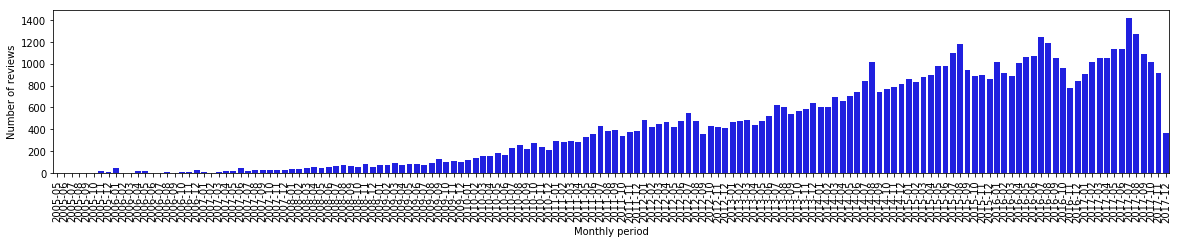

In [298]:
f, ax = plt.subplots(figsize=(20, 3))
g = sns.barplot(x="date", y="review_id",data=date_summary,color="b")
plt.xlabel('Monthly period')
plt.ylabel('Number of reviews')
plt.xticks(rotation=90)
plt.show()

## Only keep reviews later than 2012

In [299]:
df_reviews = df_reviews.loc[df_reviews.date.dt.year >= 2012, :]

## Number of Reviews by Business

In [300]:
rf = df_reviews['business_id'].value_counts()
rf.quantile([0.05,0.1,0.2,0.3,0.4,0.5])

0.05     3.0
0.10     3.0
0.20     5.0
0.30     7.0
0.40    10.0
0.50    16.0
Name: business_id, dtype: float64

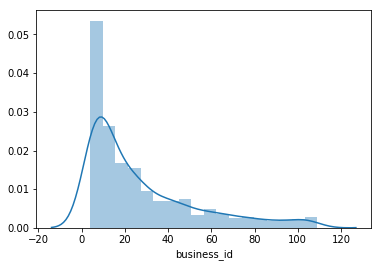

In [301]:
review_by_business_freq = rf[(rf>rf.quantile(0.10)) & (rf<rf.quantile(0.90))]
sns.distplot(review_by_business_freq)

In [302]:
business_id_with_30_plus_reviews = set(rf[rf >= 30].index)
print('There is a total of', str(len(business_id_with_30_plus_reviews)), 'Toronto restaurants with more than 30 reviews')

There is a total of 452 Toronto restaurants with more than 30 reviews


In [303]:
## Only keep reviews for business with more than 30 reviews

In [304]:
%%time
df_reviews = extract_attributes(cols = ['user_id', 'business_id','stars','date','text'],
                                 raw_json = RAW_REVIEW_JSON, 
                                 filter = lambda x: x['business_id'] in business_id_with_30_plus_reviews)
print('There is a total of ', len(df_reviews), 'reviews in the filtered review set')

now reading no.  1000000
now reading no.  2000000
now reading no.  3000000
now reading no.  4000000
now reading no.  5000000
There is a total of  53957 reviews in the filtered review set
CPU times: user 2min, sys: 30.4 s, total: 2min 31s
Wall time: 2min 46s


In [305]:
backup = df_reviews

##  Distribution of Rating

Scewed towards higher scores

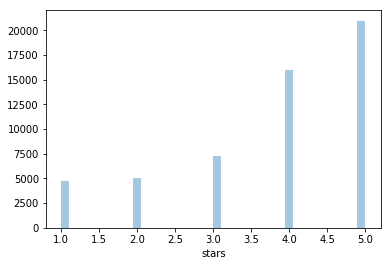

In [306]:
sns.distplot(df_reviews.stars.dropna(), kde=False)

## Number of Reviews by User

In [307]:
date_summary = df_reviews.groupby(df_reviews['user_id']).agg({'text':'count', 'stars': 'mean'}).reset_index()
date_summary.columns = ['user_id','count','stars']

In [308]:
date_summary.sort_values(by = "count", ascending = False).head()

,user_id,count,stars
13165,Xxvz5g67eaCr3emnkY5M6w,156,3.557692
15791,dt9IHwfuZs9D9LOH7gjNew,150,4.140000
10901,RylA6VZUTRuMGBu4nHKbCw,139,4.057554
9247,NfU0zDaTMEQ4-X9dbQWd9A,122,4.139344
10096,PrwnAL82LL4Ewt_wJpHWCA,105,3.780952


In [309]:
review_count_by_user = date_summary['count']
review_count_by_user.describe()

count    24218.000000
mean         2.227971
std          4.566695
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        156.000000
Name: count, dtype: float64

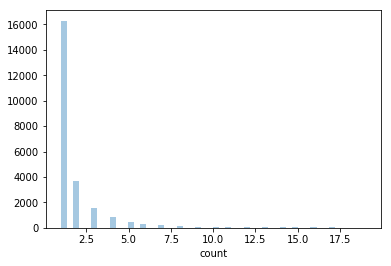

In [310]:
sns.distplot(review_count_by_user[review_count_by_user < 20], kde=False)

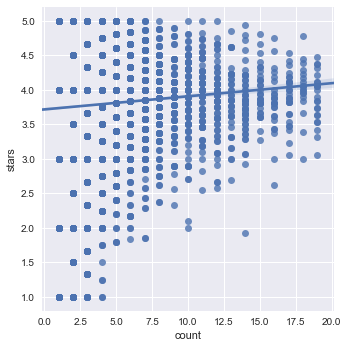

In [311]:
sns.set(color_codes=True)
sns.lmplot(x="count", y="stars", data=date_summary[date_summary['count']<20])

## Only keep users with more than 10 reviews

In [312]:
user_id_10_plus = set(date_summary.loc[date_summary['count']>=10, 'user_id'])
print('There is a total of', str(len(user_id_10_plus)), ' users with more than 10 reviews')

There is a total of 711  users with more than 10 reviews


In [313]:
df_reviews = df_reviews[df_reviews.user_id.isin(user_id_10_plus)] 
print('There are a total of ', str(len(df_reviews)), ' reviews after filtering')

There are a total of  14872  reviews after filtering


Export as csv

In [314]:
df_reviews.to_csv('./data/yelp/filtered_review.csv', index=False)

# Load Data from previous results

In [2]:
df_reviews = pd.read_csv('./data/yelp/filtered_review.csv')

In [3]:
df_reviews.head()

,user_id,business_id,stars,date,text
0,0I9NYzozlJoz1n82qcgNHw,nJrFxROYx9sis3acKkhzgA,5,2014-03-24,WAITING:\n- Sunday night at 7pm. Waited 5 minu...
1,0I9NYzozlJoz1n82qcgNHw,QUjJmpTQvGus8WfYq1dtOw,3,2012-12-23,"Food is good, but this is a really small resta..."
2,0I9NYzozlJoz1n82qcgNHw,jRAUH6Ypc_2rX_nh3NMqcQ,5,2012-04-19,"Wednesday, 1/2 off sushi day! Arrived at 6:30 ..."
3,0I9NYzozlJoz1n82qcgNHw,AbPQf-X7awuPFDULiJ43bg,5,2011-11-14,Superior Pho is awesome.\n\nThere are many pho...
4,0I9NYzozlJoz1n82qcgNHw,wftmt-n8OUA4Ng3bWWH5dw,4,2011-11-14,Shrimp wonton egg noodle soup was really good!...


## Prepare user-business matrix

Re-code user_id and business_id

In [4]:
user_labels, user_uniques = pd.factorize(df_reviews.user_id)
busi_labels, busi_uniques = pd.factorize(df_reviews.business_id)
df_reviews['user_id_index'] = user_labels
df_reviews['business_id_index']= busi_labels
n_users = len(user_uniques)
n_busi  = len(busi_uniques)
print ('Number of users = ' , str(n_users) + ' | Number of businesses = ', str(n_busi))

Number of users =  711 | Number of businesses =  452


In [5]:
df_reviews.head(2)

,user_id,business_id,stars,date,text,user_id_index,business_id_index
0,0I9NYzozlJoz1n82qcgNHw,nJrFxROYx9sis3acKkhzgA,5,2014-03-24,WAITING:\n- Sunday night at 7pm. Waited 5 minu...,0,0
1,0I9NYzozlJoz1n82qcgNHw,QUjJmpTQvGus8WfYq1dtOw,3,2012-12-23,"Food is good, but this is a really small resta...",0,1


Generate user-business matrix

In [6]:
matrix_reviews = np.zeros((n_users, n_busi))
for line in df_reviews.itertuples():
    matrix_reviews[line[-2], line[-1]] = line[3]
matrix_reviews.shape

(711, 452)

In [8]:
print('There is a total of ', sum(sum(matrix_reviews > 0)), ' Ratings in the matrix')

There is a total of  14872  Ratings in the matrix


In [9]:
print('Sparsity: ', sum(sum(matrix_reviews == 0))/ (n_users * n_busi) * 100, '%')

Sparsity:  95.37234108758697 %


## Split training and validation set

In [10]:
random.seed(1)
val_user_id_indexs = random.sample(range(n_users), int(n_users / 2))
val_busi_id_indexs = random.sample(range(n_busi),  int(n_busi/ 2))
val_user_ids = user_uniques[val_user_id_indexs]
val_busi_ids = busi_uniques[val_busi_id_indexs]

In [11]:
val_idx = (df_reviews.user_id.isin(val_user_ids)) & (df_reviews.business_id.isin(val_busi_ids))
df_reviews_train = df_reviews[~val_idx]
df_reviews_val   = df_reviews[val_idx]
print('There is a total of ', len(df_reviews_train), 'training data')
print('There is a total of ', len(df_reviews_val), 'validation data')

There is a total of  11499 training data
There is a total of  3373 validation data


In [12]:
matrix_reviews_train = np.copy(matrix_reviews)
matrix_reviews_val   = np.zeros_like(matrix_reviews)

In [13]:
for i in val_user_id_indexs:
    for j in val_busi_id_indexs:
        matrix_reviews_val[i,j] = matrix_reviews[i,j]
        matrix_reviews_train[i,j] = 0

In [14]:
print('There is a total of ', sum(sum(matrix_reviews_val >0)), ' valid ratings in the matrix to be predicted')

There is a total of  3373  valid ratings in the matrix to be predicted


In [15]:
print('Sparsity: ', sum(sum(matrix_reviews_train > 0))/ (n_users  /2 * n_busi/2 * 3) * 100, '%')

Sparsity:  4.770795215513486 %


In [16]:
print('Sparsity: ', sum(sum(matrix_reviews_val > 0))/ (n_users  /2 * n_busi/2) * 100, '%')

Sparsity:  4.198250003111658 %


# Collaborating Filtering - Memory-based

## Define Similarity

In [17]:
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

In [18]:
matrix_reviews_sp = sparse.csr_matrix(matrix_reviews_train)
matrix_reviews_sp.shape

(711, 452)

In [19]:
user_similarity = cosine_similarities(matrix_reviews_sp.T)
user_similarity.shape

(711, 711)

In [20]:
item_similarity = cosine_similarities(matrix_reviews_sp)
item_similarity.shape

(452, 452)

# Calculate prediction

In [21]:
def ui_predict(ratings, similarity):
    all_user_mean = ratings.mean(axis = 1)
    ratings_diff = (ratings - all_user_mean[:, np.newaxis]) # (943, 1682)
    
    adjust = similarity.dot(ratings_diff)
    norm = np.array([np.abs(similarity).sum(axis=1)]).T

    pred = all_user_mean[:, np.newaxis] + adjust / norm
    
    return pred

In [22]:
def ii_predict(ratings, similarity):
    norm = np.array([np.abs(similarity).sum(axis=1)])
    pred = ratings.dot(similarity)  / norm
    return pred

In [23]:
ui_predictions = ui_predict(matrix_reviews, np.array(user_similarity.todense()))
ui_predictions.shape

(711, 452)

In [24]:
ii_predictions = ii_predict(matrix_reviews, np.array(item_similarity.todense()))
ii_predictions.shape

(711, 452)

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [33]:
mean_squared_error (matrix_reviews_val,ui_predictions)


0.23281693239819967

In [34]:
mean_squared_error (matrix_reviews_val,ii_predictions)


0.22007077168980066

TBA: Evaluation

# Collaborative Filtering - Matrix Factorization

In [36]:
from scipy.sparse.linalg import svds

In [37]:
u, s, vt = svds(matrix_reviews, k = 20)
s_diag_matrix = np.diag(s)
mf_prediction = np.dot(np.dot(u, s_diag_matrix), vt)

# Evaluation

In [38]:
mean_squared_error (matrix_reviews_val,mf_prediction)

0.32187255000655735

In [39]:
mean_absolute_error (matrix_reviews_val,mf_prediction)

0.2668011341459199

WKH

- **Please add function to evaluate memory-based CF and maxtrix-factorization based CF**
    - For users in validation set, get predicted rating, and compare with observed rating.
- **Please do some research on what would be a good evaluation metric**

nlp workflow tbd

# Phrase Model

## Filter out rules for tokens

In [ ]:
#https://stackoverflow.com/questions/47523112/detect-stopword-after-lemma-in-spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS  # import stop words from language data

stop_words_getter = lambda token: token.is_stop or token.lower_ in STOP_WORDS or token.lemma_ in STOP_WORDS
Token.set_extension('is_stop', getter=stop_words_getter)  # set attribute with getter

In [447]:
# define rules to filter out unuseful tokens
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or \
       token.lemma_ == '-PRON-' or \
       token._.is_stop):
        return(False)
    else:
        return(True)

test

In [469]:
from spacy.tokens import Token
doc = nlp(u'I Had an apple, recommend')
for token in doc:
    print(token.lemma_, filter_token(token))

-PRON- False
have False
an False
apple True
, False
recommend True


In [449]:
MAX_NUM = 10 ** 10 # number of records for testing
review_texts = df_reviews_train.text
len(review_texts)

11499

## Prepare Sentence (tokens) List

TO DO:  change to per doc 

- Process
    1. filter out based on rules
    2. lemmatize
    
    
- Output:  
**[**<br/>
[sentence 1 token 1, sentence 1 token 2], ..., [sentence 1 token K1],<br/>
[sentence 2 token 1, sentence 2 token 2], ..., [sentence 2 token K2],<br/>
...<br/>
[sentence N token 1, sentence N token 2], ..., [sentence N token KN]<br/>
**]**

In [452]:
def generate_list(all_reviews, max_num = MAX_NUM):
    df = []
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=128, n_threads=-1), # parallel processing
                     range(max_num)):                                     # only MAX_NUM files
        if _ % 1000 == 0:
            print('Processing Record No: ', _)
        for sent in doc.sents:
            df.append( [token.lemma_ for token in sent if filter_token(token)]) 
    return(df)

In [453]:
unigram_sentences = generate_list(all_reviews = review_texts)
len(unigram_sentences) # Number of sentences

Processing Record No:  0
Processing Record No:  1000
Processing Record No:  2000
Processing Record No:  3000
Processing Record No:  4000
Processing Record No:  5000
Processing Record No:  6000
Processing Record No:  7000
Processing Record No:  8000
Processing Record No:  9000
Processing Record No:  10000
Processing Record No:  11000


138254

In [454]:
unigram_sentences[:5]

[['wait', 'sunday', 'night', 'p.m.'],
 ['wait', 'minute', 'seat'],
 ['reservation'],
 ['minute', 'wait', 'course'],
 ['service']]

## Train phrase model

In [455]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [456]:
bigram_model = Phraser(Phrases(unigram_sentences))
trigram_model = Phraser(Phrases(bigram_model[unigram_sentences]))

## Apply Phrase Model

- Process
    1. filter out based on rules
    2. lemmatize
    3. apply bigram and trigram phrase model


- Output:  
**[**<br/>
[Doc 1 token 1, Doc 1 token 2], ..., [Doc 1 token K1],<br/>
[Doc 2 token 1, Doc 2 token 2], ..., [Doc 2 token K2],<br/>
...<br/>
[Doc N token 1, Doc N token 2], ..., [Doc N token KN]<br/>
**]**

In [473]:
def apply_phrase_model(all_reviews, max_num = MAX_NUM):
    df = []
    
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=128, n_threads=-1),
                   range(max_num)):
        if _ % 1000 == 0:
            print('Processing Record No: ', _)
        unigram_review =  [token.lemma_ for token in doc if filter_token(token)]
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
        df.append(trigram_review)
    return(df)

In [474]:
phrased_reviews = apply_phrase_model(all_reviews = review_texts)
len(phrased_reviews)

Processing Record No:  0
Processing Record No:  1000
Processing Record No:  2000
Processing Record No:  3000
Processing Record No:  4000
Processing Record No:  5000
Processing Record No:  6000
Processing Record No:  7000
Processing Record No:  8000
Processing Record No:  9000
Processing Record No:  10000
Processing Record No:  11000


11499

Take a look at bi- and tri- grams

In [475]:
' / '.join([word for phrased_review in phrased_reviews for word in phrased_review if '_' in word ][:100])

"sunday_night / wait_minute_seat / water_refill / highly_recommend / medium_rare / bone_marrow / bone_marrow / pickle_veggie / bone_marrow / bone_marrow / pork_chop / highly_recommend / cook_thoroughly / pickle_vegetable / highly_recommend / rich_creamy / friday_night / 6:30_pm / sit_bar / right_away / pay_$ / superior_pho / superior_pho / shrimp_wonton / noodle_soup / japanese_raman / fellow_yelper / appetizer_entree / egg_benedict / crab_cake / beer_sampler / duck_breast / portion_small / grumpy_'s / grumpy_'s_special / pumpkin_pancake / pumpkin_pancake / pita_bread / duck_confit / crispy_skin / pickle_veggie / personally_prefer / fine_dining / pork_chop / pork_belly / pork_chop / pork_chop / blow_away / fine_dining / pork_belly / bit_salty / blow_away / pork_chop / theater_district / playhouse_square / zack_bruell_'s / french_influence / asian_fusion / crispy_pork_shank / serve_bed / collard_green / pig_face / greenhouse_tavern / fine_dining / right_middle / university_circle / seve

Take a example to compare before-after

In [481]:
review_texts[1]

'Food is good, but this is a really small restaurant with maybe 5 tables. I made a reservation at 7:30pm on a Friday night, and my plate came around 8:45pm.'

In [479]:
' '.join(phrased_reviews[1])

'food good small restaurant maybe table reservation 7:30pm friday_night plate come 8:45pm'

export and save

In [460]:
pd.DataFrame({'Text':phrased_reviews}).to_csv('./data/yelp/phrased_review_text.csv',index=False)

# TF-IDF

take a look at first document

In [482]:
review_corpus = [' '.join(phrased_review) for phrased_review in phrased_reviews]
review_corpus[1]

'food good small restaurant maybe table reservation 7:30pm friday_night plate come 8:45pm'

Convert corpus to tf-idf

In [483]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

In [690]:
vectorizer = TfidfVectorizer(max_features = 1000, min_df = 10, max_df = 0.5)
review_tfidf = vectorizer.fit_transform(review_corpus)
review_tfidf = review_tfidf.toarray()
review_tfidf.shape

(11499, 1000)

# Doc2Vec

In [528]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(phrased_reviews)]
model = Doc2Vec(documents, vector_size=50, window=2, min_count=10)

In [537]:
vector = model.infer_vector(phrased_reviews[0])
vector

array([ 2.0443067e-01, -2.1173112e-01,  2.2620941e-02,  1.3187550e-01,
       -4.2346340e-01,  2.3472923e-01,  2.3147410e-04, -2.7711233e-01,
       -5.8996511e-01,  2.5665709e-01, -1.1268180e-01, -1.5433340e-01,
       -8.9820594e-01,  1.8724166e-01,  2.1242417e-01,  1.2088243e-01,
        2.0525116e-01,  5.8550283e-02,  2.0885500e-01,  4.2424563e-01,
        2.4723703e-01,  3.9891872e-01, -1.7118868e-01, -2.5412515e-01,
       -1.2077720e-01,  3.4614548e-01,  1.4009205e-01, -6.5345734e-02,
       -5.9150946e-01, -1.2130043e-01, -1.3082936e-01,  1.4153665e-01,
       -6.1782360e-02, -2.3748159e-01, -2.0949683e-01, -1.7621729e-01,
       -5.3435189e-01, -2.8631049e-01, -1.4634185e-01, -1.8093112e-01,
        1.0118710e-03,  6.9514118e-02, -2.9454246e-01,  4.2137373e-02,
       -3.2423818e-01, -3.1490618e-01, -2.5646520e-01,  2.2756824e-01,
       -1.2683416e-02, -5.3429985e-01], dtype=float32)

In [536]:
model.wv.most_similar('terrible')

[('hit_miss', 0.9822902083396912),
 ('horrible', 0.9807307124137878),
 ('impressed', 0.9674456119537354),
 ('tad_slow', 0.9617175459861755),
 ('quick_friendly', 0.9580111503601074),
 ('awful', 0.9576153755187988),
 ('spotty', 0.9479000568389893),
 ('consistent', 0.9451117515563965),
 ('bit_slow', 0.9418869018554688),
 ('stellar', 0.940416693687439)]

array([[ 0.22563349, -0.280808  ,  0.08232561, ...,  0.16603695,
        -0.04366383, -0.64979136],
       [ 0.06881094, -0.00553519,  0.08337709, ..., -0.0614541 ,
        -0.05115002,  0.03014365],
       [ 0.26634175, -0.0160048 ,  0.1068439 , ...,  0.10672714,
        -0.05938787,  0.14064279],
       ...,
       [ 0.18371642, -0.13418317,  0.19008158, ...,  0.08216576,
        -0.07891114, -0.15459333],
       [ 0.24292184, -0.15369001, -0.07265995, ..., -0.07927258,
         0.09562643, -0.09003723],
       [ 0.17481156, -0.28763038, -0.00550267, ...,  0.08197158,
        -0.02466185, -0.16948463]], dtype=float32)

In [694]:
review_vec = np.array([model.infer_vector(phrased_review) for phrased_review in phrased_reviews])
review_vec.shape

(11499, 50)

# Content-based Filtering

- covert attributes into binary matrix
- Think about attributes
- covert past text review into attributes/vectros

In [845]:
X_business = extract_attributes(cols = ['business_id','review_count','attributes','categories'], 
                                raw_json = RAW_BUSINESS_JSON, 
                                filter = lambda x: x['business_id'] in business_id_with_30_plus_reviews)
X_business.head(1)

,business_id,review_count,attributes,categories
322,VGRn5KgYKMkqdIKtBUzQQA,100,"{'RestaurantsTableService': True, 'GoodForMeal...","[American (Traditional), Burgers, Restaurants]"


In [846]:
category_names = set([c for record in X_business.categories for c in record])
print('There is a total of ', len(category_names), 'category names.')

There is a total of  162 category names.


In [847]:
attribute_names = set([k for record in X_business.attributes for k, v in record.items()])
print('There is a total of ', len(attribute_names), 'attribute names.')

There is a total of  36 attribute names.


TO DO: Add columns for categories (attribute is a bit complicated"

In [848]:
category_dict = {}
i = 0
for category_name in category_names:
    category_dict[category_name] = i
    i += 1

In [849]:
for i in range(len(category_names)):
    X_business['cate_' + str(i)] = 0

In [850]:
for (idx, row)  in X_business.iterrows():
    for category_name in row.loc['categories']:
        colname = 'cate_' + str(category_dict[category_name])
        X_business.loc[idx, colname] = 1

In [851]:
del X_business['attributes']
del X_business['categories']

In [852]:
X_business.head(1)

,business_id,review_count,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5,cate_6,cate_7,...,cate_152,cate_153,cate_154,cate_155,cate_156,cate_157,cate_158,cate_159,cate_160,cate_161
322,VGRn5KgYKMkqdIKtBUzQQA,100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [853]:
X_tfidf = pd.DataFrame(review_tfidf)
X_tfidf.columns = ['tfidf_' + str(col) for col in X_tfidf.columns]
X_tfidf.head(1)

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074873,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [854]:
X_vec = pd.DataFrame(review_vec)
X_vec.columns = ['vec_' + str(col) for col in X_vec.columns]
X_vec.head(1)

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_40,vec_41,vec_42,vec_43,vec_44,vec_45,vec_46,vec_47,vec_48,vec_49
0,0.267408,-0.237174,-0.031425,0.120963,-0.406361,0.161255,0.035122,-0.312016,-0.565835,0.184866,...,0.074188,0.042894,-0.261367,0.140307,-0.240221,-0.205042,-0.193841,0.176015,0.165008,-0.561549


In [863]:
d = len(review_vec)
W = np.zeros((d,d))
for i in range(d):
    W[i, i] = df_reviews.loc[i, "stars"]

In [866]:
weighted_X_vec = pd.DataFrame(np.dot(W, X_vec), columns= X_vec.columns)
weighted_X_vec.head(1)

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_40,vec_41,vec_42,vec_43,vec_44,vec_45,vec_46,vec_47,vec_48,vec_49
0,1.33704,-1.185868,-0.157124,0.604815,-2.031806,0.806275,0.17561,-1.560081,-2.829173,0.924331,...,0.370941,0.21447,-1.306835,0.701536,-1.201103,-1.025208,-0.969203,0.880073,0.825041,-2.807743


In [869]:
X_review = df_reviews_train[['user_id','business_id']]
X_review = pd.concat([X_review, weighted_X_vec], axis=1)
X_review = X_review.merge(X_business, how='inner', left_on="business_id", right_on = 'business_id')
X_review.head(1)

,user_id,business_id,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,...,cate_152,cate_153,cate_154,cate_155,cate_156,cate_157,cate_158,cate_159,cate_160,cate_161
0,0I9NYzozlJoz1n82qcgNHw,nJrFxROYx9sis3acKkhzgA,1.33704,-1.185868,-0.157124,0.604815,-2.031806,0.806275,0.17561,-1.560081,...,0,0,0,0,0,0,0,0,0,0


In [873]:
business_profile = X_review.groupby('business_id').agg("mean").reset_index().set_index('business_id')
user_profile     = X_review.groupby('user_id').agg("mean").reset_index().set_index('user_id')

In [992]:
u_id = val_user_ids[0]
u = user_profile.loc[[u_id],:]
val_busi_ids_for_u = df_reviews_val.loc[(df_reviews_val.user_id == u_id), 'business_id']
i = business_profile.loc[val_busi_ids_for_u,:]

In [993]:
from sklearn.preprocessing import scale

In [999]:
from sklearn.metrics.pairwise import cosine_similarity
u_i = scale(pd.concat([u,i], axis=0))
sim = cosine_similarity(u_i)[0][1:]
reco = pd.concat([pd.Series(i.index), pd.Series(sim)], axis = 1).\
                                    rename(columns = {0: 'sim'}).\
                                    sort_values(by = 'sim', ascending = False)
reco.merge(df_reviews_val.loc[(df_reviews_val.user_id == u_id),['business_id','stars']], how='left', left_on='business_id', right_on='business_id')

,business_id,sim,stars
0,vdloJPM3bSpQTMlwdFek2A,0.120329,4
1,7W_PUqiBmoe2PVFGQ1ZBOg,0.076386,3
2,LWk7Q5CTjpK-k_TfXdbApQ,-0.006948,5
3,bupMXFUaZfranBLdaVcRww,-0.009705,5
4,68kpmZBEb6x7wG1HBeLQ3g,-0.036986,5
5,1gQrMs-I8oKg2p-iRxznzQ,-0.047308,5
6,MX3TL4-ij22rLFBD1XjKGw,-0.050492,5
7,F2pfjAZ_3dMTGCKv6c5wOw,-0.084684,5
8,AbPQf-X7awuPFDULiJ43bg,-0.143845,5
9,LvnOhs9Udhyp5adF7Cq98g,-0.157477,3


In [995]:
five_star = &(df_reviews_val.stars == 5), ['business_id']]
five_star 

,business_id
2965,OD2dbQTKN7FS01fHzZqqzA
2966,MX3TL4-ij22rLFBD1XjKGw
2969,LWk7Q5CTjpK-k_TfXdbApQ
2973,Xny0n0s98TpP82sQxfgIMQ
2974,68kpmZBEb6x7wG1HBeLQ3g
2977,F2pfjAZ_3dMTGCKv6c5wOw
2978,bupMXFUaZfranBLdaVcRww
2980,AbPQf-X7awuPFDULiJ43bg
2983,pM5OiwjOih7twp4mP0Rmhw
3394,1gQrMs-I8oKg2p-iRxznzQ


# Topic Modelling - `gensim`

<img src="https://s3.amazonaws.com/skipgram-images/LDA.png" width= 600>

In [485]:
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim as gensimvis
import pyLDAvis

Create gensim `dictionary`

In [486]:
dictionary = corpora.Dictionary(phrased_reviews)
print(dictionary)

Dictionary(27056 unique tokens: ['add', 'animalistic', 'appetizer', 'awakening', 'balance']...)


In [487]:
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=1000)
print(dictionary)

Dictionary(1000 unique tokens: ['add', 'appetizer', 'balance', 'big', 'bone']...)


An example of using dictionary (essentially just document-term matrix)

In [488]:
' '.join(phrased_reviews[1])

'food good small restaurant maybe table reservation 7:30pm friday_night plate come 8:45pm'

In [489]:
dictionary.doc2bow(phrased_reviews[1])

[(41, 1), (51, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)]

Create gensim `corpus`

In [490]:
corpus = [dictionary.doc2bow(phrased_review) for phrased_review in phrased_reviews]
corpora.MmCorpus.serialize('./model/yelp_gensim_corpus.mm', corpus)  # store to disk, for later use
corpus = corpora.MmCorpus('./model/yelp_gensim_corpus.mm')

In [491]:
corpus[1]

[(41, 1.0),
 (51, 1.0),
 (60, 1.0),
 (61, 1.0),
 (62, 1.0),
 (63, 1.0),
 (64, 1.0),
 (65, 1.0)]

Train LDA model

In [499]:
lda = LdaMulticore(corpus, 
                   num_topics = 4, 
                   id2word = dictionary)

Take a look at top terms in first topic

In [505]:
lda.show_topic(0, topn=10)

[('order', 0.018269729),
 ('time', 0.016887577),
 ('great', 0.013228033),
 ('try', 0.0122539755),
 ('come', 0.0117835635),
 ('$', 0.010572886),
 ('menu', 0.00966181),
 ('like', 0.009472199),
 ('love', 0.00945592),
 ('restaurant', 0.008623779)]

Visualization

In [506]:
vis_data  = gensimvis.prepare(lda, corpus, dictionary)

In [507]:
pyLDAvis.display(vis_data)

# Topic Modeling - `textacy`

Create Document-Term Matrix

In [511]:
vectorizer = textacy.vsm.Vectorizer(tf_type='linear', min_df = 10, max_n_terms=1000)
doc_term_matrix = vectorizer.fit_transform(phrased_reviews)
doc_term_matrix

<11499x1000 sparse matrix of type '<class 'numpy.int32'>'
	with 382548 stored elements in Compressed Sparse Row format>

Train Topic Model

In [512]:
model = textacy.tm.TopicModel('lda', n_topics=5) 
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(11499, 5)

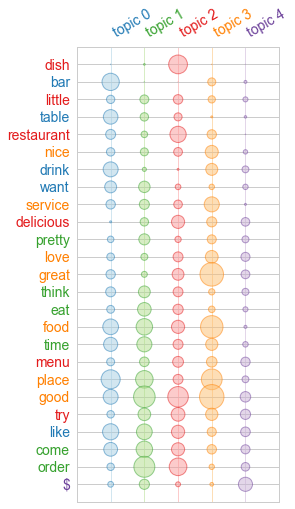

In [513]:
model.termite_plot(doc_term_matrix,  
                   vectorizer.id_to_term,
                   highlight_topics=[0,1,2,3,4])

# Sentiment Analysis

## Prepare constant length reviews

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


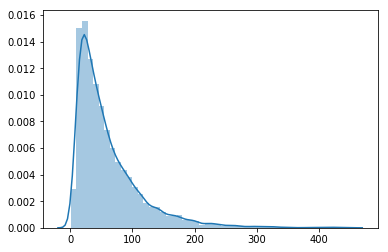

In [221]:
sns.distplot([len(review) for review in phrased_reviews])

In [222]:
def pad_trim_review(review, MAX_LEN = 50):
    l = len(review)
    if  l >= MAX_LEN:
        return(review[:MAX_LEN])
    else:
        return(review + ['<PAD/>'] * (MAX_LEN - l))

In [223]:
pad_trim_review(phrased_reviews[0])[:5],pad_trim_review(phrased_reviews[0])[-5:]

(['love', 'staff', 'love', 'meat', 'love'],
 ['<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>'])

## Generate index-based input

In [224]:
dictionary = corpora.Dictionary(phrased_reviews)
phrased_reviews_padded = [pad_trim_review(x) for x in phrased_reviews]
phrased_reviews_padded_index = [dictionary.doc2idx(x, unknown_word_index=len(dictionary)) for x in phrased_reviews_padded]

In [225]:
VOCAB_SIZE = len(dictionary) + 1
VOCAB_SIZE

31198

In [226]:
phrased_reviews_padded_index[0][:5], phrased_reviews_padded_index[0][-5:]

([12, 22, 12, 15, 12], [31197, 31197, 31197, 31197, 31197])

In [227]:
phrased_reviews_padded_index = np.array(phrased_reviews_padded_index)
phrased_reviews_padded_index.shape

(10000, 50)

## Extract target

In [228]:
def generate_stars():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield(review['stars'])

In [229]:
stars = [star for star, _ in zip(generate_stars(), range(MAX_NUM))]
stars[:5]

[5, 5, 5, 5, 4]

In [230]:
stars = np.array(stars).reshape(-1,1)
stars.shape

(10000, 1)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


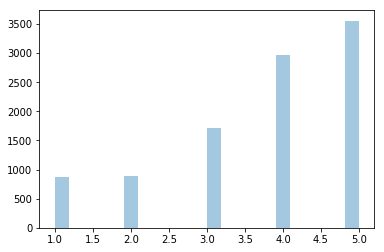

In [231]:
sns.distplot(stars,kde=False)

## Generate Training and Testing set

In [279]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) # continous
data.shape

(10000, 51)

In [274]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) #binary
data = data[data[:,-1] != 3]
data[:,-1] = [0 if x < 3 else 1 for x in data[:,-1]]
data.shape

(8284, 51)

In [280]:
random.seed(1)
np.random.shuffle(data)
train, test = train_test_split(data, test_size = 0.15,random_state = 0)
X_train = train[:,:-1]
X_test = test[:,:-1]
Y_train = train[:,-1]
Y_test = test[:,-1]

## Define LSTM network

In [281]:
MAX_LEN = 50
VOCAB_SIZE
embedding_dim = 25
lstm_units = 120
batch_size = 64

In [282]:
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE, 
                    output_dim = embedding_dim, 
                    input_length = MAX_LEN))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units = lstm_units, 
               dropout = 0.2,  
               recurrent_dropout = 0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='relu')) # continous
#model.add(Dense(1, activation='sigmoid')) # binary
model.summary()

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 25)            779950    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 50, 25)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 120)               70080     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                7260      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 61        
Total params: 857,351
Trainable params: 857,351
Non-trainable params: 0
_________________________________________________________________


/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


## Model training

In [278]:
model.compile(loss='binary_crossentropy', 
              optimizer = optimizers.Adam(lr=0.001), 
              metrics=['accuracy'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 7041 samples, validate on 1243 samples
Epoch 1/10
7041/7041 [==============================] - 10s 1ms/step - loss: 0.5405 - acc: 0.7823 - val_loss: 0.4969 - val_acc: 0.7916
Epoch 2/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.4128 - acc: 0.8350 - val_loss: 0.4094 - val_acc: 0.8648
Epoch 3/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.2646 - acc: 0.9068 - val_loss: 0.3203 - val_acc: 0.8850
Epoch 4/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1965 - acc: 0.9359 - val_loss: 0.3240 - val_acc: 0.8954
Epoch 5/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1357 - acc: 0.9565 - val_loss: 0.3098 - val_acc: 0.8817
Epoch 6/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1029 - acc: 0.9692 - val_loss: 0.3255 - val_acc: 0.8914
Epoch 7/10
7041/7041 [==============================] - 7s 963us/step - loss: 0.0807 - acc: 0.9768 - val_loss: 0.3245 - val_acc: 0.8825
Epoch 8/10


In [283]:
model.compile(loss='mean_squared_error', 
              optimizer= optimizers.Adam(lr=0.001), 
              metrics=['mae'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 8500 samples, validate on 1500 samples
Epoch 1/10
8500/8500 [==============================] - 11s 1ms/step - loss: 3.4113 - mean_absolute_error: 1.4562 - val_loss: 1.5131 - val_mean_absolute_error: 0.9669
Epoch 2/10
8500/8500 [==============================] - 8s 995us/step - loss: 2.0851 - mean_absolute_error: 1.1789 - val_loss: 1.4755 - val_mean_absolute_error: 1.0007
Epoch 3/10
8500/8500 [==============================] - 8s 976us/step - loss: 2.0436 - mean_absolute_error: 1.1654 - val_loss: 1.4726 - val_mean_absolute_error: 1.0302
Epoch 4/10
8500/8500 [==============================] - 8s 979us/step - loss: 1.7889 - mean_absolute_error: 1.0782 - val_loss: 1.1768 - val_mean_absolute_error: 0.8571
Epoch 5/10
8500/8500 [==============================] - 8s 989us/step - loss: 1.5029 - mean_absolute_error: 0.9856 - val_loss: 1.1340 - val_mean_absolute_error: 0.8390
Epoch 6/10
8500/8500 [==============================] - 9s 1ms/step - loss: 1.2611 - mean_absolute_error: 0.8955 